## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras
import itertools
from keras.regularizers import l1_l2

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=0.0, l2_ratio=0.0):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
"""
Set your hyper-parameters
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-2, 1e-4, 1e-8, 1e-12, 0.0]
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12, 0.0]

In [7]:
results = {}
"""
Set your training loop
"""
for l1r, l2r in itertools.product(L1_EXP, L2_EXP):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with L1 = %.6f, L2 = %.6f" % (l1r, l2r))
    model = build_mlp(input_shape=x_train.shape[1:], l1_ratio=l1r, l2_ratio=l2r)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l1-%s-l2-%s" % (str(l1r), str(l2r))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with L1 = 0.010000, L2 = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [=============

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 6s 115us/step - loss: 198.5150 - acc: 0.2365 - val_loss: 40.9658 - val_acc: 0.2747
Epoch 2/50
50000/50000 [==============================] - 5s 105us/step - loss: 18.9889 - acc: 0.1169 - val_loss: 7.1943 - val_acc: 0.1000
Epoch 3/50
50000/50000 [==============================] - 5s 105us/step - loss: 4.0663 - acc: 0.1000 - val_loss: 2.6356 - val_acc: 0.1000
Epoch 4/50
50000/50000 [==============================] - 5s 105us/step - loss: 2.4840 - acc: 0.0981 - val_loss: 2.4624 - val_acc: 0.1000
Epoch 5/50
50000/50000 [==============================] - 5s 104us/step - loss: 2.4626 - acc: 0.0974 - val_loss: 2.4624 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 5s 105us/step - loss: 2.4626 - acc: 0.0961 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 5s 104us/step - loss: 2.4626 - acc: 0.0984 - val_loss: 2.462

Epoch 2/50
50000/50000 [==============================] - 5s 105us/step - loss: 19.1475 - acc: 0.1177 - val_loss: 7.3110 - val_acc: 0.1000
Epoch 3/50
50000/50000 [==============================] - 5s 106us/step - loss: 4.1183 - acc: 0.0973 - val_loss: 2.6535 - val_acc: 0.1000
Epoch 4/50
50000/50000 [==============================] - 6s 113us/step - loss: 2.4875 - acc: 0.0960 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 5/50
50000/50000 [==============================] - 6s 115us/step - loss: 2.4626 - acc: 0.0989 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 6s 115us/step - loss: 2.4626 - acc: 0.0987 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 6s 116us/step - loss: 2.4626 - acc: 0.0982 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 8/50
50000/50000 [==============================] - 17s 340us/step - loss: 2.4626 - acc: 0.0977 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 9/50
50000/50000 [========

50000/50000 [==============================] - 8s 151us/step - loss: 4.1108 - acc: 0.0989 - val_loss: 2.6485 - val_acc: 0.1000
Epoch 4/50
50000/50000 [==============================] - 8s 151us/step - loss: 2.4859 - acc: 0.0993 - val_loss: 2.4627 - val_acc: 0.1000
Epoch 5/50
50000/50000 [==============================] - 7s 150us/step - loss: 2.4626 - acc: 0.0994 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 8s 151us/step - loss: 2.4626 - acc: 0.0976 - val_loss: 2.4627 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 7s 150us/step - loss: 2.4626 - acc: 0.0961 - val_loss: 2.4627 - val_acc: 0.1000
Epoch 8/50
50000/50000 [==============================] - 7s 149us/step - loss: 2.4626 - acc: 0.0978 - val_loss: 2.4627 - val_acc: 0.1000
Epoch 9/50
50000/50000 [==============================] - 8s 151us/step - loss: 2.4626 - acc: 0.0961 - val_loss: 2.4627 - val_acc: 0.1000
Epoch 10/50
50000/50000 [====================

50000/50000 [==============================] - 7s 143us/step - loss: 2.4859 - acc: 0.0997 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 5/50
50000/50000 [==============================] - 8s 153us/step - loss: 2.4626 - acc: 0.0977 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 8s 161us/step - loss: 2.4626 - acc: 0.0986 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 8s 155us/step - loss: 2.4626 - acc: 0.0980 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 8/50
50000/50000 [==============================] - 8s 154us/step - loss: 2.4626 - acc: 0.0964 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 9/50
50000/50000 [==============================] - 8s 159us/step - loss: 2.4626 - acc: 0.0983 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 10/50
50000/50000 [==============================] - 9s 170us/step - loss: 2.4626 - acc: 0.0982 - val_loss: 2.4624 - val_acc: 0.1000
Epoch 11/50
50000/50000 [===================

Epoch 5/50
50000/50000 [==============================] - 13s 251us/step - loss: 10.5495 - acc: 0.3954 - val_loss: 9.8436 - val_acc: 0.3969
Epoch 6/50
50000/50000 [==============================] - 12s 247us/step - loss: 9.2125 - acc: 0.4014 - val_loss: 8.6105 - val_acc: 0.3994
Epoch 7/50
50000/50000 [==============================] - 12s 249us/step - loss: 8.0735 - acc: 0.4048 - val_loss: 7.5595 - val_acc: 0.4099
Epoch 8/50
50000/50000 [==============================] - 12s 246us/step - loss: 7.1010 - acc: 0.4128 - val_loss: 6.6639 - val_acc: 0.4158
Epoch 9/50
50000/50000 [==============================] - 12s 242us/step - loss: 6.2741 - acc: 0.4182 - val_loss: 5.9038 - val_acc: 0.4180
Epoch 10/50
50000/50000 [==============================] - 12s 244us/step - loss: 5.5711 - acc: 0.4191 - val_loss: 5.2629 - val_acc: 0.4175
Epoch 11/50
50000/50000 [==============================] - 13s 251us/step - loss: 4.9712 - acc: 0.4230 - val_loss: 4.6988 - val_acc: 0.4248
Epoch 12/50
50000/50000 

50000/50000 [==============================] - 12s 248us/step - loss: 5.4516 - acc: 0.4349 - val_loss: 5.4015 - val_acc: 0.4424
Epoch 6/50
50000/50000 [==============================] - 12s 249us/step - loss: 5.3442 - acc: 0.4485 - val_loss: 5.3017 - val_acc: 0.4451 7s - loss: 5.3771 - acc:  - ETA: 6s -  - ETA: 4s - loss: 5.3613 - acc: 0.449 - ETA: 4s
Epoch 7/50
50000/50000 [==============================] - 13s 252us/step - loss: 5.2438 - acc: 0.4597 - val_loss: 5.2222 - val_acc: 0.45212s -
Epoch 8/50
50000/50000 [==============================] - 12s 249us/step - loss: 5.1501 - acc: 0.4684 - val_loss: 5.1229 - val_acc: 0.4628
Epoch 9/50
50000/50000 [==============================] - 12s 249us/step - loss: 5.0570 - acc: 0.4781 - val_loss: 5.0421 - val_acc: 0.4627
Epoch 10/50
50000/50000 [==============================] - 12s 247us/step - loss: 4.9685 - acc: 0.4842 - val_loss: 4.9619 - val_acc: 0.4705
Epoch 11/50
50000/50000 [==============================] - 11s 223us/step - loss: 4.8

50000/50000 [==============================] - 13s 254us/step - loss: 5.3402 - acc: 0.4303 - val_loss: 5.3061 - val_acc: 0.4227
Epoch 6/50
50000/50000 [==============================] - 12s 248us/step - loss: 5.2387 - acc: 0.4449 - val_loss: 5.2030 - val_acc: 0.4439
Epoch 7/50
50000/50000 [==============================] - 12s 246us/step - loss: 5.1441 - acc: 0.4563 - val_loss: 5.1173 - val_acc: 0.4501
Epoch 8/50
50000/50000 [==============================] - 13s 250us/step - loss: 5.0544 - acc: 0.4653 - val_loss: 5.0346 - val_acc: 0.45665.0650 - - ETA: 2s - loss: 5.0627 - acc:  - ETA
Epoch 9/50
50000/50000 [==============================] - 12s 248us/step - loss: 4.9684 - acc: 0.4753 - val_loss: 4.9496 - val_acc: 0.4631
Epoch 10/50
50000/50000 [==============================] - 13s 250us/step - loss: 4.8840 - acc: 0.4811 - val_loss: 4.8699 - val_acc: 0.4744
Epoch 11/50
50000/50000 [==============================] - 13s 250us/step - loss: 4.8024 - acc: 0.4905 - val_loss: 4.7997 - val_a

50000/50000 [==============================] - 13s 251us/step - loss: 5.4527 - acc: 0.4144 - val_loss: 5.3954 - val_acc: 0.4208
Epoch 5/50
50000/50000 [==============================] - 13s 254us/step - loss: 5.3423 - acc: 0.4318 - val_loss: 5.2995 - val_acc: 0.4335
Epoch 6/50
50000/50000 [==============================] - 13s 252us/step - loss: 5.2425 - acc: 0.4438 - val_loss: 5.2077 - val_acc: 0.4417
Epoch 7/50
50000/50000 [==============================] - 13s 259us/step - loss: 5.1490 - acc: 0.4564 - val_loss: 5.1120 - val_acc: 0.4562
Epoch 8/50
50000/50000 [==============================] - 13s 259us/step - loss: 5.0576 - acc: 0.4662 - val_loss: 5.0325 - val_acc: 0.4568
Epoch 9/50
50000/50000 [==============================] - 12s 247us/step - loss: 4.9725 - acc: 0.4756 - val_loss: 4.9547 - val_acc: 0.4666
Epoch 10/50
50000/50000 [==============================] - 13s 253us/step - loss: 4.8870 - acc: 0.4826 - val_loss: 4.8704 - val_acc: 0.4719
Epoch 11/50
50000/50000 [============

50000/50000 [==============================] - 14s 274us/step - loss: 5.4584 - acc: 0.4156 - val_loss: 5.4213 - val_acc: 0.4153
Epoch 5/50
50000/50000 [==============================] - 13s 266us/step - loss: 5.3509 - acc: 0.4301 - val_loss: 5.3067 - val_acc: 0.4319
Epoch 6/50
50000/50000 [==============================] - 13s 260us/step - loss: 5.2488 - acc: 0.4433 - val_loss: 5.2071 - val_acc: 0.4430
Epoch 7/50
50000/50000 [==============================] - 9s 174us/step - loss: 5.1550 - acc: 0.4530 - val_loss: 5.1294 - val_acc: 0.4477
Epoch 8/50
50000/50000 [==============================] - 9s 174us/step - loss: 5.0667 - acc: 0.4630 - val_loss: 5.0370 - val_acc: 0.4573
Epoch 9/50
50000/50000 [==============================] - 9s 172us/step - loss: 4.9791 - acc: 0.4733 - val_loss: 4.9632 - val_acc: 0.4646
Epoch 10/50
50000/50000 [==============================] - 9s 173us/step - loss: 4.8937 - acc: 0.4822 - val_loss: 4.9014 - val_acc: 0.4573
Epoch 11/50
50000/50000 [================

50000/50000 [==============================] - 13s 253us/step - loss: 9.9215 - acc: 0.3976 - val_loss: 9.2866 - val_acc: 0.4019
Epoch 5/50
50000/50000 [==============================] - 13s 256us/step - loss: 8.7223 - acc: 0.4101 - val_loss: 8.1772 - val_acc: 0.4114
Epoch 6/50
50000/50000 [==============================] - 13s 258us/step - loss: 7.7010 - acc: 0.4166 - val_loss: 7.2440 - val_acc: 0.4157
Epoch 7/50
50000/50000 [==============================] - 13s 256us/step - loss: 6.8302 - acc: 0.4233 - val_loss: 6.4339 - val_acc: 0.4254
Epoch 8/50
50000/50000 [==============================] - 13s 255us/step - loss: 6.0862 - acc: 0.4298 - val_loss: 5.7632 - val_acc: 0.4221
Epoch 9/50
50000/50000 [==============================] - 12s 250us/step - loss: 5.4514 - acc: 0.4346 - val_loss: 5.1678 - val_acc: 0.4305
Epoch 10/50
50000/50000 [==============================] - 13s 253us/step - loss: 4.9086 - acc: 0.4397 - val_loss: 4.6674 - val_acc: 0.4390
Epoch 11/50
50000/50000 [============

50000/50000 [==============================] - 12s 241us/step - loss: 1.8138 - acc: 0.4111 - val_loss: 1.7934 - val_acc: 0.4133
Epoch 5/50
50000/50000 [==============================] - 12s 235us/step - loss: 1.7689 - acc: 0.4275 - val_loss: 1.7635 - val_acc: 0.4252
Epoch 6/50
50000/50000 [==============================] - 12s 236us/step - loss: 1.7286 - acc: 0.4423 - val_loss: 1.7149 - val_acc: 0.4453
Epoch 7/50
50000/50000 [==============================] - 12s 239us/step - loss: 1.6933 - acc: 0.4536 - val_loss: 1.6937 - val_acc: 0.4492
Epoch 8/50
50000/50000 [==============================] - 12s 240us/step - loss: 1.6636 - acc: 0.4674 - val_loss: 1.6788 - val_acc: 0.4504
Epoch 9/50
50000/50000 [==============================] - 12s 242us/step - loss: 1.6352 - acc: 0.4766 - val_loss: 1.6397 - val_acc: 0.4618
Epoch 10/50
50000/50000 [==============================] - 12s 240us/step - loss: 1.6098 - acc: 0.4823 - val_loss: 1.6303 - val_acc: 0.4684
Epoch 11/50
50000/50000 [============

Epoch 5/50
50000/50000 [==============================] - 12s 239us/step - loss: 1.6273 - acc: 0.4300 - val_loss: 1.6137 - val_acc: 0.4345
Epoch 6/50
50000/50000 [==============================] - 12s 239us/step - loss: 1.5887 - acc: 0.4421 - val_loss: 1.5903 - val_acc: 0.4338
Epoch 7/50
50000/50000 [==============================] - 12s 240us/step - loss: 1.5565 - acc: 0.4545 - val_loss: 1.5604 - val_acc: 0.4457
Epoch 8/50
50000/50000 [==============================] - 12s 240us/step - loss: 1.5241 - acc: 0.4658 - val_loss: 1.5356 - val_acc: 0.4558
Epoch 9/50
50000/50000 [==============================] - 12s 238us/step - loss: 1.4979 - acc: 0.4759 - val_loss: 1.5136 - val_acc: 0.4650
Epoch 10/50
50000/50000 [==============================] - 12s 238us/step - loss: 1.4699 - acc: 0.4851 - val_loss: 1.4943 - val_acc: 0.4739
Epoch 11/50
50000/50000 [==============================] - 12s 240us/step - loss: 1.4480 - acc: 0.4909 - val_loss: 1.4798 - val_acc: 0.4764
Epoch 12/50
50000/50000 [

Epoch 6/50
50000/50000 [==============================] - 12s 243us/step - loss: 1.5856 - acc: 0.4456 - val_loss: 1.5809 - val_acc: 0.4443
Epoch 7/50
50000/50000 [==============================] - 12s 241us/step - loss: 1.5507 - acc: 0.4572 - val_loss: 1.5537 - val_acc: 0.4501
Epoch 8/50
50000/50000 [==============================] - 12s 238us/step - loss: 1.5210 - acc: 0.4682 - val_loss: 1.5327 - val_acc: 0.4633
Epoch 9/50
50000/50000 [==============================] - 12s 238us/step - loss: 1.4933 - acc: 0.4774 - val_loss: 1.5285 - val_acc: 0.4629
Epoch 10/50
50000/50000 [==============================] - 12s 240us/step - loss: 1.4683 - acc: 0.4843 - val_loss: 1.4950 - val_acc: 0.4707
Epoch 11/50
50000/50000 [==============================] - 12s 240us/step - loss: 1.4452 - acc: 0.4930 - val_loss: 1.5015 - val_acc: 0.4702
Epoch 12/50
50000/50000 [==============================] - 12s 237us/step - loss: 1.4216 - acc: 0.4996 - val_loss: 1.4617 - val_acc: 0.4807
Epoch 13/50
50000/50000 

Epoch 7/50
50000/50000 [==============================] - 13s 263us/step - loss: 1.5472 - acc: 0.4580 - val_loss: 1.5553 - val_acc: 0.4540
Epoch 8/50
50000/50000 [==============================] - 13s 257us/step - loss: 1.5149 - acc: 0.4711 - val_loss: 1.5317 - val_acc: 0.4598
Epoch 9/50
50000/50000 [==============================] - 13s 258us/step - loss: 1.4879 - acc: 0.4767 - val_loss: 1.5214 - val_acc: 0.4610s - loss: 1.4868 - acc: 0. - ETA: 2s -  - ETA: 0s - loss: 1.4897 - a
Epoch 10/50
50000/50000 [==============================] - 13s 261us/step - loss: 1.4625 - acc: 0.4860 - val_loss: 1.4892 - val_acc: 0.4731
Epoch 11/50
50000/50000 [==============================] - 13s 262us/step - loss: 1.4395 - acc: 0.4932 - val_loss: 1.4738 - val_acc: 0.4801
Epoch 12/50
50000/50000 [==============================] - 13s 262us/step - loss: 1.4173 - acc: 0.5004 - val_loss: 1.4559 - val_acc: 0.4845
Epoch 13/50
50000/50000 [==============================] - 13s 262us/step - loss: 1.3943 - acc:

50000/50000 [==============================] - 12s 239us/step - loss: 6.8468 - acc: 0.4204 - val_loss: 6.4508 - val_acc: 0.4244
Epoch 8/50
50000/50000 [==============================] - 12s 237us/step - loss: 6.0993 - acc: 0.4278 - val_loss: 5.7604 - val_acc: 0.4312
Epoch 9/50
50000/50000 [==============================] - 12s 237us/step - loss: 5.4602 - acc: 0.4324 - val_loss: 5.1798 - val_acc: 0.4288
Epoch 10/50
50000/50000 [==============================] - 12s 240us/step - loss: 4.9171 - acc: 0.4370 - val_loss: 4.6770 - val_acc: 0.4366
Epoch 11/50
50000/50000 [==============================] - 12s 240us/step - loss: 4.4508 - acc: 0.4421 - val_loss: 4.2414 - val_acc: 0.4431
Epoch 12/50
50000/50000 [==============================] - 12s 237us/step - loss: 4.0524 - acc: 0.4458 - val_loss: 3.8908 - val_acc: 0.4405
Epoch 13/50
50000/50000 [==============================] - 12s 234us/step - loss: 3.7130 - acc: 0.4510 - val_loss: 3.5823 - val_acc: 0.4409
Epoch 14/50
50000/50000 [=========

50000/50000 [==============================] - 12s 243us/step - loss: 1.6723 - acc: 0.4639 - val_loss: 1.7078 - val_acc: 0.4458
Epoch 8/50
50000/50000 [==============================] - 12s 240us/step - loss: 1.6448 - acc: 0.4746 - val_loss: 1.6592 - val_acc: 0.4697
Epoch 9/50
50000/50000 [==============================] - 12s 239us/step - loss: 1.6184 - acc: 0.4828 - val_loss: 1.6634 - val_acc: 0.4591
Epoch 10/50
50000/50000 [==============================] - 12s 239us/step - loss: 1.5925 - acc: 0.4919 - val_loss: 1.6192 - val_acc: 0.4791
Epoch 11/50
50000/50000 [==============================] - 12s 241us/step - loss: 1.5697 - acc: 0.4987 - val_loss: 1.6082 - val_acc: 0.4808
Epoch 12/50
50000/50000 [==============================] - 12s 239us/step - loss: 1.5478 - acc: 0.5068 - val_loss: 1.6039 - val_acc: 0.4796
Epoch 13/50
50000/50000 [==============================] - 12s 240us/step - loss: 1.5276 - acc: 0.5115 - val_loss: 1.6099 - val_acc: 0.4777
Epoch 14/50
50000/50000 [=========

50000/50000 [==============================] - 12s 241us/step - loss: 1.5460 - acc: 0.4596 - val_loss: 1.5474 - val_acc: 0.4536
Epoch 8/50
50000/50000 [==============================] - 12s 242us/step - loss: 1.5150 - acc: 0.4690 - val_loss: 1.5307 - val_acc: 0.4548
Epoch 9/50
50000/50000 [==============================] - 12s 243us/step - loss: 1.4860 - acc: 0.4801 - val_loss: 1.5070 - val_acc: 0.4706
Epoch 10/50
50000/50000 [==============================] - 12s 243us/step - loss: 1.4623 - acc: 0.4883 - val_loss: 1.4861 - val_acc: 0.4738
Epoch 11/50
50000/50000 [==============================] - 12s 245us/step - loss: 1.4351 - acc: 0.4974 - val_loss: 1.5146 - val_acc: 0.4643
Epoch 12/50
50000/50000 [==============================] - 12s 244us/step - loss: 1.4135 - acc: 0.5030 - val_loss: 1.4522 - val_acc: 0.4838
Epoch 13/50
50000/50000 [==============================] - 12s 241us/step - loss: 1.3910 - acc: 0.5114 - val_loss: 1.4395 - val_acc: 0.4896
Epoch 14/50
50000/50000 [=========

50000/50000 [==============================] - 12s 241us/step - loss: 1.5521 - acc: 0.4585 - val_loss: 1.5617 - val_acc: 0.4508
Epoch 8/50
50000/50000 [==============================] - 12s 240us/step - loss: 1.5225 - acc: 0.4681 - val_loss: 1.5360 - val_acc: 0.4582
Epoch 9/50
50000/50000 [==============================] - 12s 239us/step - loss: 1.4940 - acc: 0.4777 - val_loss: 1.5213 - val_acc: 0.4623
Epoch 10/50
50000/50000 [==============================] - 12s 243us/step - loss: 1.4677 - acc: 0.4859 - val_loss: 1.5089 - val_acc: 0.4660
Epoch 11/50
50000/50000 [==============================] - 12s 244us/step - loss: 1.4430 - acc: 0.4937 - val_loss: 1.5048 - val_acc: 0.4640
Epoch 12/50
50000/50000 [==============================] - 12s 244us/step - loss: 1.4205 - acc: 0.5007 - val_loss: 1.4752 - val_acc: 0.4760
Epoch 13/50
50000/50000 [==============================] - 12s 242us/step - loss: 1.3998 - acc: 0.5082 - val_loss: 1.4541 - val_acc: 0.4889
Epoch 14/50
50000/50000 [=========

50000/50000 [==============================] - 11s 219us/step - loss: 1.5545 - acc: 0.4542 - val_loss: 1.5653 - val_acc: 0.4487
Epoch 8/50
50000/50000 [==============================] - 7s 142us/step - loss: 1.5254 - acc: 0.4661 - val_loss: 1.5374 - val_acc: 0.4544
Epoch 9/50
50000/50000 [==============================] - 10s 200us/step - loss: 1.4983 - acc: 0.4747 - val_loss: 1.5296 - val_acc: 0.4564
Epoch 10/50
50000/50000 [==============================] - 13s 259us/step - loss: 1.4739 - acc: 0.4828 - val_loss: 1.5184 - val_acc: 0.4621
Epoch 11/50
50000/50000 [==============================] - 13s 263us/step - loss: 1.4498 - acc: 0.4907 - val_loss: 1.4819 - val_acc: 0.4699
Epoch 12/50
50000/50000 [==============================] - 13s 266us/step - loss: 1.4255 - acc: 0.5013 - val_loss: 1.4708 - val_acc: 0.4789
Epoch 13/50
50000/50000 [==============================] - 13s 262us/step - loss: 1.4054 - acc: 0.5083 - val_loss: 1.4448 - val_acc: 0.4820
Epoch 14/50
50000/50000 [==========

50000/50000 [==============================] - 13s 263us/step - loss: 6.8333 - acc: 0.4211 - val_loss: 6.4394 - val_acc: 0.4283
Epoch 8/50
50000/50000 [==============================] - 13s 264us/step - loss: 6.0894 - acc: 0.4263 - val_loss: 5.7564 - val_acc: 0.4268
Epoch 9/50
50000/50000 [==============================] - 13s 262us/step - loss: 5.4559 - acc: 0.4300 - val_loss: 5.1753 - val_acc: 0.4281
Epoch 10/50
50000/50000 [==============================] - 13s 267us/step - loss: 4.9124 - acc: 0.4366 - val_loss: 4.6787 - val_acc: 0.4330
Epoch 11/50
50000/50000 [==============================] - 13s 259us/step - loss: 4.4477 - acc: 0.4412 - val_loss: 4.2465 - val_acc: 0.4357oss: 4.4711  - ETA: 0s - loss: 4.4540 - acc: 0.4 - ETA: 0s - loss: 4.4510 - acc: 0.4
Epoch 12/50
50000/50000 [==============================] - 13s 261us/step - loss: 4.0505 - acc: 0.4460 - val_loss: 3.8793 - val_acc: 0.4370
Epoch 13/50
50000/50000 [==============================] - 13s 261us/step - loss: 3.7112 -

50000/50000 [==============================] - 13s 263us/step - loss: 1.6807 - acc: 0.4606 - val_loss: 1.6872 - val_acc: 0.4582
Epoch 8/50
50000/50000 [==============================] - 13s 266us/step - loss: 1.6544 - acc: 0.4677 - val_loss: 1.6857 - val_acc: 0.4423
Epoch 9/50
50000/50000 [==============================] - 13s 264us/step - loss: 1.6259 - acc: 0.4777 - val_loss: 1.6530 - val_acc: 0.4658
Epoch 10/50
50000/50000 [==============================] - 13s 259us/step - loss: 1.6011 - acc: 0.4845 - val_loss: 1.6322 - val_acc: 0.4723
Epoch 11/50
50000/50000 [==============================] - 13s 264us/step - loss: 1.5775 - acc: 0.4941 - val_loss: 1.6194 - val_acc: 0.4775
Epoch 12/50
50000/50000 [==============================] - 13s 259us/step - loss: 1.5546 - acc: 0.5038 - val_loss: 1.5910 - val_acc: 0.4893
Epoch 13/50
50000/50000 [==============================] - 13s 263us/step - loss: 1.5329 - acc: 0.5089 - val_loss: 1.5939 - val_acc: 0.4823 - loss: 1.5323 - acc: 0.
Epoch 14/

50000/50000 [==============================] - 13s 265us/step - loss: 1.5359 - acc: 0.4613 - val_loss: 1.5364 - val_acc: 0.4569
Epoch 8/50
50000/50000 [==============================] - 13s 268us/step - loss: 1.5046 - acc: 0.4744 - val_loss: 1.5288 - val_acc: 0.4573
Epoch 9/50
50000/50000 [==============================] - 13s 262us/step - loss: 1.4777 - acc: 0.4832 - val_loss: 1.4935 - val_acc: 0.4690
Epoch 10/50
50000/50000 [==============================] - 13s 263us/step - loss: 1.4506 - acc: 0.4905 - val_loss: 1.4762 - val_acc: 0.4730
Epoch 11/50
50000/50000 [==============================] - 13s 269us/step - loss: 1.4267 - acc: 0.4992 - val_loss: 1.4775 - val_acc: 0.4801
Epoch 12/50
50000/50000 [==============================] - 13s 258us/step - loss: 1.4048 - acc: 0.5055 - val_loss: 1.4519 - val_acc: 0.4852
Epoch 13/50
50000/50000 [==============================] - 13s 265us/step - loss: 1.3841 - acc: 0.5133 - val_loss: 1.4252 - val_acc: 0.4936
Epoch 14/50
50000/50000 [=========

50000/50000 [==============================] - 13s 265us/step - loss: 1.5435 - acc: 0.4581 - val_loss: 1.5666 - val_acc: 0.4476
Epoch 8/50
50000/50000 [==============================] - 13s 260us/step - loss: 1.5153 - acc: 0.4678 - val_loss: 1.5338 - val_acc: 0.4551
Epoch 9/50
50000/50000 [==============================] - 13s 261us/step - loss: 1.4867 - acc: 0.4768 - val_loss: 1.5080 - val_acc: 0.463676
Epoch 10/50
50000/50000 [==============================] - 13s 261us/step - loss: 1.4596 - acc: 0.4858 - val_loss: 1.4949 - val_acc: 0.4663
Epoch 11/50
50000/50000 [==============================] - 13s 260us/step - loss: 1.4356 - acc: 0.4958 - val_loss: 1.4659 - val_acc: 0.4797
Epoch 12/50
50000/50000 [==============================] - 13s 261us/step - loss: 1.4138 - acc: 0.5025 - val_loss: 1.4739 - val_acc: 0.4724
Epoch 13/50
50000/50000 [==============================] - 13s 260us/step - loss: 1.3924 - acc: 0.5116 - val_loss: 1.4348 - val_acc: 0.4900
Epoch 14/50
50000/50000 [=======

Epoch 8/50
50000/50000 [==============================] - 11s 211us/step - loss: 1.5133 - acc: 0.4692 - val_loss: 1.5286 - val_acc: 0.4590
Epoch 9/50
50000/50000 [==============================] - 11s 217us/step - loss: 1.4837 - acc: 0.4783 - val_loss: 1.5232 - val_acc: 0.4584
Epoch 10/50
50000/50000 [==============================] - 11s 216us/step - loss: 1.4592 - acc: 0.4886 - val_loss: 1.4970 - val_acc: 0.4691
Epoch 11/50
50000/50000 [==============================] - 11s 216us/step - loss: 1.4352 - acc: 0.4940 - val_loss: 1.4800 - val_acc: 0.4744
Epoch 12/50
50000/50000 [==============================] - 11s 211us/step - loss: 1.4107 - acc: 0.5020 - val_loss: 1.4560 - val_acc: 0.4837
Epoch 13/50
50000/50000 [==============================] - 11s 219us/step - loss: 1.3910 - acc: 0.5115 - val_loss: 1.4450 - val_acc: 0.4846
Epoch 14/50
50000/50000 [==============================] - 11s 213us/step - loss: 1.3695 - acc: 0.5156 - val_loss: 1.4441 - val_acc: 0.4881
Epoch 15/50
50000/5000

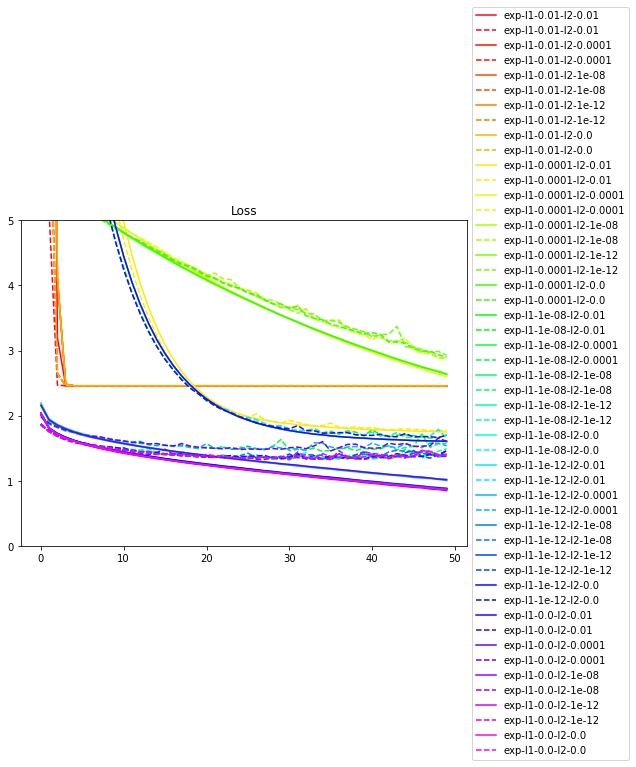

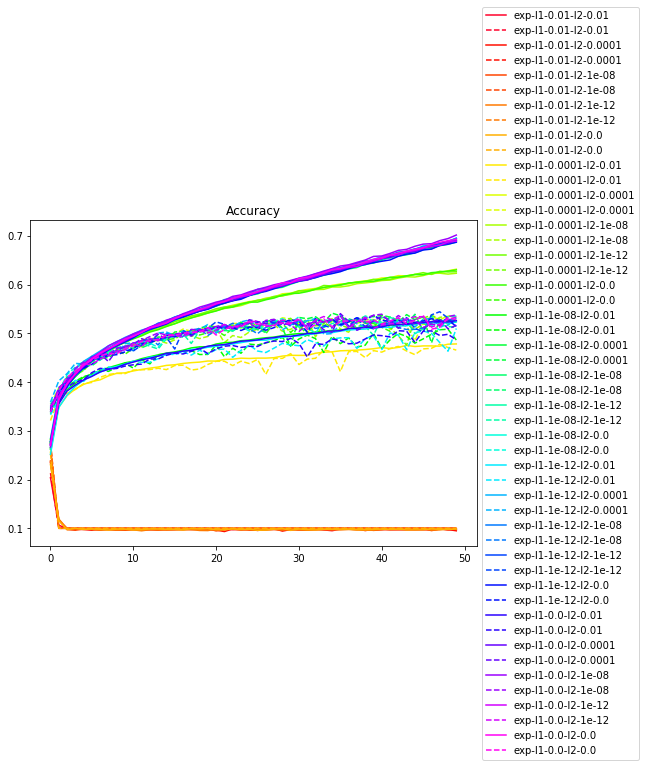

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
"""
plot the results
"""
NUM_COLORS = len(results.keys())
cm = plt.get_cmap('gist_rainbow')
color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()